### `Time Series Analysis in Python | Putting It All Together`


#### `01: A Dog on a Leash? (Part 1)`
The Heating Oil and Natural Gas prices are pre-loaded in DataFrames `HO` and `NG`. First, plot both price series, which look like random walks. Then plot the difference between the two series, which should look more like a mean reverting series (to put the two series in the same units, we multiply the heating oil prices, in $/gallon, by 7.25, which converts it to $/millionBTU, which is the same units as Natural Gas).

The data for continuous futures (each contract has to be spliced together in a continuous series as contracts expire) was obtained from Quandl.

- Plot Heating Oil, `HO`, and Natural Gas, `NG`, on the same subplot
  - Make sure you multiply the `HO` price by `7.25` to match the units of `NG`
- Plot the spread on a second subplot
  - The spread will be `7.25*HO - NG`

In [15]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt 
HO = pd.read_csv("datasets/HO.csv", index_col=0)
NG = pd.read_csv("datasets/NG.csv", index_col=0)

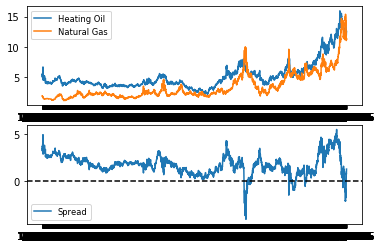

In [16]:
# Plot the prices separately
plt.subplot(2,1,1)
plt.plot(7.25 * HO, label='Heating Oil')
plt.plot(NG, label='Natural Gas')
plt.legend(loc='best', fontsize='small')

# Plot the spread
plt.subplot(2,1,2)
plt.plot(7.25 * HO - NG, label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

Notice from the plot that when Heating Oil briefly dipped below Natural Gas, it quickly reverted back up.


#### `02: A Dog on a Leash? (Part 2)`
To verify that Heating Oil and Natural Gas prices are cointegrated, First apply the Dickey-Fuller test separately to show they are random walks. Then apply the test to the difference, which should strongly reject the random walk hypothesis. The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG.

- Perform the adfuller test on `HO` and on `NG` separately, and save the results (results are a list)
  - The argument for adfuller must be a series, so you need to include the column `'Close'`
  - Print just the p-value (item [1] in the list)
- Do the same thing for the spread, again converting the units of `HO`, and using the column `'Close'` of each DataFrame

In [17]:
# Import the adfuller module from statsmodels
from statsmodels.tsa.stattools import adfuller

# Compute the ADF for HO and NG
result_HO = adfuller(HO['Close'])
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(NG['Close'])
print("The p-value for the ADF test on NG is ", result_NG[1])

# Compute the ADF of the spread
result_spread = adfuller(7.25 * HO - NG)
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on HO is  0.9567679189664411
The p-value for the ADF test on NG is  0.9008747444676729
The p-value for the ADF test on the spread is  7.002441030586384e-05


As we expected, we cannot reject the hypothesis that the individual futures are random walks, but we can reject that the spread is a random walk.



#### `03: Are Bitcoin and Ethereum Cointegrated?`
Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression. In the last example, there was no need to perform the first step since we implicitly assumed the cointegration vector was (1,-1)
. In other words, we took the difference between the two series (after doing a units conversion). Here, you will do both steps.

You will regress the value of one cryptocurrency, bitcoin (BTC), on another cryptocurrency, ethereum (ETH). If we call the regression coefficient 
(1, -b), then the cointegration vector is simply 
. Then perform the ADF test on BTC - `b` ETH. Bitcoin and Ethereum prices are pre-loaded in DataFrames `BTC` and `ETH`.


- Import the statsmodels module for regression and the `adfuller` function
- Add a constant to the `ETH` DataFrame using `sm.add_constant()`
- Regress `BTC` on `ETH` using `sm.OLS(y,x).fit()`, where y is the dependent variable and x is the independent variable, and save the results in `result`.
    - The intercept is in `result.params[0]` and the slope in `result.params[1]`
- Run ADF test on BTC -`b`ETH

In [18]:
BTC = pd.read_csv("datasets/BTC.csv", index_col=0)
ETH = pd.read_csv("datasets/ETH.csv", index_col=0)

In [19]:
# Import the statsmodels module for regression and the adfuller function
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Regress BTC on ETH
ETH = sm.add_constant(ETH)
result = sm.OLS(BTC,ETH).fit()

# Compute ADF
b = result.params[1]
adf_stats = adfuller(BTC['Price'] - b*ETH['Price'])
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  0.023369002323473033


The data suggests that Bitcoin and Ethereum are cointegrated.



#### `04: Is Temperature a Random Walk (with Drift)?`
An ARMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this class.

The DataFrame temp_NY contains the average annual temperature in Central Park, NY from 1870-2016 (the data was downloaded from the NOAA here). Plot the data and test whether it follows a random walk (with drift).

- Convert the index of years into a datetime object using `pd.to_datetime()`, and since the data is annual, pass the argument `format='%Y'`.
- Plot the data using `.plot()`
- Compute the p-value the Augmented Dickey Fuller test using the `adfuller` function.
- Save the results of the ADF test in `result`, and print out the p-value in `result[1]`.

In [21]:
temp_NY = pd.read_csv("datasets/NOAA_TAVG.csv", index_col=0)
temp_NY.head()

,TAVG
DATE,
1870,53.8
1871,51.3
1872,51.3
1873,50.9
1874,51.3


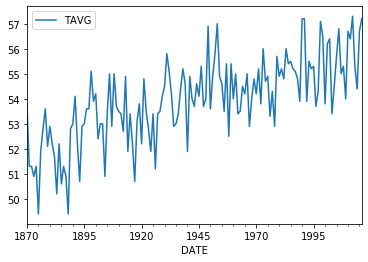

The p-value for the ADF test is  0.583293898787114


In [22]:
# Import the adfuller function from the statsmodels module
from statsmodels.tsa.stattools import adfuller

# Convert the index to a datetime object
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')

# Plot average temperatures
temp_NY.plot()
plt.show()

# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

The data seems to follow a random walk with drift.



#### `05: Getting "Warmed" Up: Look at Autocorrelations`
Since the temperature series, temp_NY, is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

- Import the modules for plotting the sample ACF and PACF
- Take first differences of the DataFrame `temp_NY` using the pandas method `.diff()`
- Create two subplots for plotting the ACF and PACF
    - Plot the sample ACF of the differenced series
    - Plot the sample PACF of the differenced series

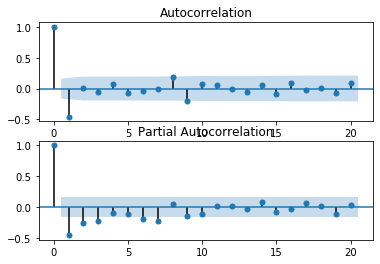

In [23]:
    # Import the modules for plotting the sample ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2,1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0])

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1])
plt.show()

There is no clear pattern in the ACF and PACF except the negative lag-1 autocorrelation in the ACF.



#### `06: Which ARMA Model is Best?`
Recall from Chapter 3 that the Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. Lower AIC scores are better.

Fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

The annual change in temperature is in a DataFrame chg_temp.


- For each ARMA model, create an instance of the `ARIMA` class, passing the data and the `order=(p,d,q)`. p is the autoregressive order; q is the moving average order; d is the number of times the series has been differenced.
- Fit the model using the method `.fit()`.
- Print the AIC value, found in the `.aic` element of the results.

In [24]:
# Import the module for estimating an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARIMA(chg_temp, order=(1, 0, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC:
mod_ar2 = ARIMA(chg_temp, order=(1, 1, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# Fit the data to an ARMA(1,1) model and print AIC:
mod_arma11 = ARIMA(chg_temp, order=(0, 0, 1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

c:\Users\MOHAMAD\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
c:\Users\MOHAMAD\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
c:\Users\MOHAMAD\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
c:\Users\MOHAMAD\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
c:\Users\MOHAMAD\AppData\Local\Programs\Python\Python36\lib\site-pac

The AIC for an AR(1) is:  510.5346898733109
The AIC for an AR(2) is:  611.566505797921
The AIC for an ARMA(1,1) is:  469.3909763914303


The ARMA(1,1) has the lowest AIC values among the three models.
- AIC (Akaike Information Criterion) is a statistical measure used to compare different models based on their goodness of fit and complexity. It was developed by the Japanese statistician Hirotugu Akaike.




#### `07: Don't Throw Out That Winter Coat Yet`
Finally, you will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, you determined that the temperature data follows a random walk and you looked at first differencing the data. In this exercise, you will use the ARIMA module on the temperature data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.

Because temperatures are trending up over time, you will also need to add a trend component when you define the ARIMA model. In the exercise, you'll use a linear trend with time by setting the argument trend='t'. You can also try other trend models to see how the forecasts change. For example, for a quadratic trend a + bt + ct^2, set trend=[0,1,1], to include both a linear term ct^2, and quadratic term, in the model.

The data is preloaded in a DataFrame called `temp_NY`.


- Create an instance of the `ARIMA` class called `mod` for an integrated ARMA(1,1) model, or ARIMA(1,1,1) model
    - The `d` in `order(p,d,q)` is one, since we first differenced once
    - Fit `mod` using the `.fit()` method and call the results `res`
- Forecast the series using the `plot_predict()` method on `res`
  - Choose the start date as `1872` and the end date as `2046`

c:\Users\MOHAMAD\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
c:\Users\MOHAMAD\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
c:\Users\MOHAMAD\AppData\Local\Programs\Python\Python36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


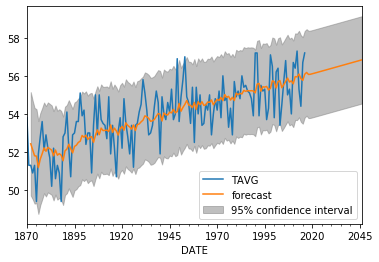

In [25]:
# Import the ARIMA module from statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, trend='t', order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
fig, ax = plt.subplots()
temp_NY.plot(ax=ax)
plot_predict(res, start='1872', end='2046', ax=ax)
plt.show()

- According to the model, the temperature is expected to be about 0.6 degrees higher in 30 years (almost entirely due to the trend), but the 95% confidence interval around that is over 5 degrees.

